# Rapport de projet de session - IFT 712
### Objectif du projet : tester six méthodes de classification sur une base de données Kaggle.

Nous avons choisi la base de données "[Heart Failure Prediction Dataset][0]" puisqu'elle permet de faire de la classification sur un jeu de données réel et avec des applications concrètes.
Les méthodes de classification que nous allons tester sont les suivantes :
* Modèle génératif
* K plus proches voisins
* Régression logistique
* Méthode à noyaux
* SVM
* Perceptron multicouches

Pour cela, nous utiliserons la bibliothèque scikit-learn pour implémenter les algotihmes ainsi que pandas  pour traiter les données

Nous utiliserons également [Trello][1] ainsi que discord afin d'organiser le projet
Le code est versionné sur [Github][1] en suivant les conventions suivantes :
* conventionals [commits][3]
* merge requests sur master
* une branche par feature (i.e par algorithme de classification)

Le code et les commentaires sont rédigés en francais et suivant la convention [pep8][4]. Nous utiliserons la fonctionnalité "code with me" de pycharm permettant à plussieurs membres du groupe de coder sur le même projet en même temps

[0]: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
[1]: https://trello.com/b/U21MHLaj/projet-ift712-deadline-11-12-23
[2]: https://github.com/MorganChabaudENSSAT/projet_ift712
[3]: https://www.conventionalcommits.org/en/v1.0.0/
[4]: https://peps.python.org/pep-0008/

In [1]:
'''
 Imporation des bibliothèques python générales
'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import warnings

'''
 Imporation des bibliothèques spécifiques au devoir
'''
from regression_logistique import RegressionLogistique
import utils

'''
    Suppression des Future Warnings 
'''
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Importation des données
df = pd.read_csv('heart.csv') # Dataframe contenant les données
features_names = df.columns
features_nbr = features_names.shape[0]
print(f"nombre de features dans le dataset : {features_nbr}")
# Visualisation des données pour mieux les comprendre
print(df.head())
print(df.dtypes)

nombre de features dans le dataset : 12
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG 

A partir de cette visualisation primaire des données, on  remarque que certaines features sont catégoriques ce qui empêche de les utiliser telles quelles dans les algorithmes de classification.
=> On va donc devoir traiter ces valeurs en les encodant.

In [3]:
le = LabelEncoder()

data = df.copy(deep = True)

data['Sex'] = le.fit_transform(data['Sex'])
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])
data['RestingECG'] = le.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])

# Les données sont mainteant toutes numériques et utilisables par les algorithmes de classification que nous mettrons en place
print(data)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

A présent, on explore les données à l'aide de visualisations afin de mieux comprendre leur nature et détecter les features les plus caractéristiques ainsi que la nature des distributions des données afin, au besoin, de formuler des hypothèses nous permettant de mettre en oeuvre différents modèles.
On commence par visualiser la distribution de chaque feature.

C:\Users\taill\AppData\Local\Temp\ipykernel_26244\1165184245.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[cur_feature], kde_kws={'bw' : 1})
C:\Users\taill\anaconda3\lib\site-packages\seaborn\distributions.py:2496: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\taill\AppData\Local\Temp\ipykernel_26244\1165184245.py:6: UserWarning: 

`distplot` is a deprecated function and will be remove

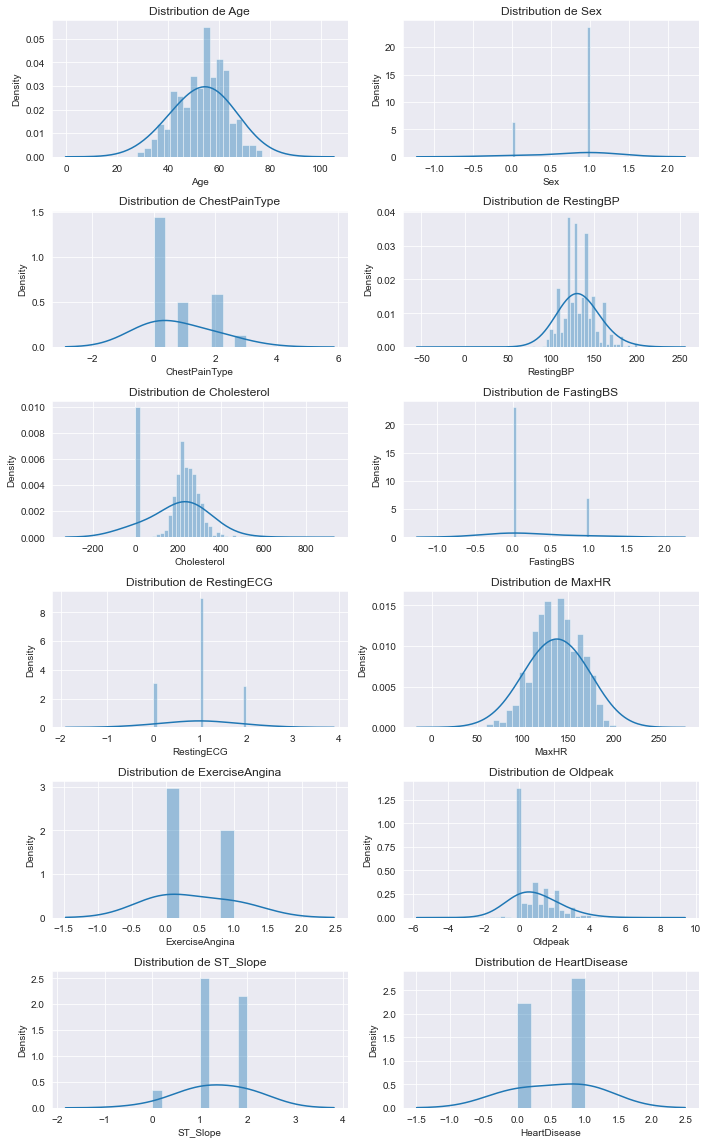

In [4]:
fig = plt.figure(figsize=(10,16))
for i in range(features_nbr):
    plt.subplot(int(features_nbr/2), 2, i+1)
    fig.tight_layout()
    cur_feature =features_names[i]
    sns.distplot(data[cur_feature], kde_kws={'bw' : 1})
    plt.title("Distribution de "+cur_feature)

Les données semblent suivre approximativement une distribution normale dans une majorité de cas. On assumera donc dans la suite du projet, lorsque cela est nécessaire que les données suivent une loi normale.

# 1 - Régression logistique #

In [5]:
# Création d'un modèle de base
reg_log=RegressionLogistique(data, features_names, features_nbr)

On met à l'echelle les données afin de réduire l'impact des différentes valeurs que peuvent prendre les données sur la précision du modèle.
La visualisation des données a mis en évidence les phénomènes suivants:
- blablabla
- ascqs
- qfds

On normalise les donées correspondant aux features ..... de sorte à les ramener entre 0 et 1
On standardise les données suivant déjà une distribution gaussienne  pour empêcher le svelurs extrèmes de fausser les résultats.

In [6]:
# Mise à echelle des données
scaled_data = reg_log.scale_data()
# Récupération des ensembles d'entraînements et de validation
X_train, X_test, y_train, y_test = reg_log.split_data(scaled_data)

In [7]:
# Entraînement du modèle sur les données d'entraînement
reg_log.train(X_train, y_train)

In [8]:
# Evaluation du modèle sur les données de test
reg_log.evaluate_model(X_test,y_test)

0.8586956521739131
Le score de validation croisée est :  0.8096096096096096 avec un déviation standard de :  0.07300694966497415
[[69 14]
 [12 89]]
accuracy du modèle : 0.8586956521739131


### Recherche d'un modèle de plus grande capacité ###
On cheche a présent à obtenir un modèle de plus grande qualité. Pour cela, on va comparer plusieurs régressions logistiques initialisées avec des hyperparamètres dfférents afin d'obtenir la combinaison optimal des hyperparamètres.
D'après le site de la bibliothèque sklearn, les hyperparamètres sur lesquels il est le plus important d'influer dans le cadre de la régression logistique et que nous étudierons en conséquence sont les suivants:
- le 'solver' c'est à dire l'algorithme d'optimisation qui minimise la loss
- 'penalty' qui correspond à la norme employée dans le terme de régularisation
- 'C' est la constante qui régule l'impact du terme de régularisation (c'est l'inverse de la force de régularisation)

Par la suite, on cherche donc a analyser les résultats des différentes combinaisons d'hyperparamètres de sorte à maximiser la capacité du système **tout en** l'empêchant d'overfitter sur les données. Pour cela, on visualiseras l'évolution de l'accuracy sur les ensembles d'entraînement et de validation en procédant à une recherche d'hyperparamètres de type 'grid-search' reposant sur la 'cross_validation'


In [9]:
h_parameters_to_tune ={
    'solver' : ['lbfgs', 'liblinear','newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty' : ['None','l2', 'l1', 'elasticnet'],
    'C' : [1.0, 10.0, 100.0, 1000.0, 10000.0]
}
grid = GridSearchCV(LogisticRegression(), h_parameters_to_tune, cv=5)
grid. fit(X_train, y_train)
print(grid.best_score_," pour les hyperparamètres suivants : ", grid.best_params_)

0.8488025347125152  pour les hyperparamètres suivants :  {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}


C:\Users\taill\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
425 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\taill\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\taill\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\taill\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 441, in _check_solver
    raise ValueError(
V

In [10]:
best_reg_log = grid.best_estimator_
best_reg_log.score(X_test, y_test) #Performance du modèle en vrai

0.8532608695652174